# 2. HMean Calculation for Text Detection & Spotting Tasks


In this notebook, we will learn how the evaluation metrics (IoU, HMean, Precision, and Recall) for text detection and spotting are computed. We will first install and import the necessary libraries; then go through the code for the evaluation methods. Lastly, we will examine examples of how the evaluation is carried out and obtain insights into each metric's measures.

**Table of Contents**

1. [Installation](#installation)
2. [Evaluation & Helper Methods](#evaluation--helper-methods)
3. [Evaluation Examples](#evaluation-examples)

Get your seatbelt on and let's get started! 🔥⭐


## Installation

In [1]:
!pip install numpy
!pip install Polygon3
!pip install Pillow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for Polygon3: filename=Polygon3-3.0.9.1-cp310-cp310-linux_x86_64.whl size=119431 sha256=e0dd7d2786ddf169b8db7b389229a3ad34206ac4d04a6bfc6f6485d9decf5532
  Stored in directory: /root/.cache/pip/wheels/d8/b7/f6/b4e24f56a1cc9856dca98cc2fdc3915d7649b39b62f3dbca9e
Successfully built Polygon3
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Evaluation & Helper Methods

In [2]:
from collections import namedtuple
import numpy as np
import Polygon as plg
from PIL import Image, ImageDraw
from typing import Dict, List

In [3]:
def evaluation(gt_dict: Dict[str, List], det_dict: Dict[str, List], eval_config: Dict):
    """Evaluate the prediction results in terms of precision, recall and HMean.
    The matching between ground-truth and predicted bounding box is based on the order in the list.
    In other words, a ground-truth box will match with the first predicted bounding box with IoU > IOU_CONSTRAINT.

    Args:
        gt_dict (Dict[str, list]): A dictionary with image id as the key and a list of its ground-truth
         bounding boxes as the value.
         e.g.: gt_dict = {'img1': [[20, 20, 120, 60, "Hello"],
                                 [200, 100, 300, 140, "World"],
                                 [80, 180, 180, 220, "###"]]}
        det_dict (Dict[str, list]): A dictionary with image id as the key and a list of its predicted
         bounding boxes as the value.
         e.g.: det_dict = {'img1': [[105, 40, 205, 80, "Hello"],
                                  [210, 105, 310, 145, "World"],
                                  [70, 170, 170, 210, "Random"]]}
        eval_config (dict): A dictionary storing the evaluation configuration.
         e.g.: eval_config = {"IOU_CONSTRAINT": 0.5,
                            "AREA_PRECISION_CONSTRAINT": 0.5,
                            "WORD_SPOTTING": True,
                        }
    Returns:
        resDict (Dict): A dict storing overall and per-sample evaluation result
    """

    def rectangle_to_polygon(rect):
        resBoxes = np.empty([1, 8], dtype="int32")
        resBoxes[0, 0] = int(rect.xmin)
        resBoxes[0, 4] = int(rect.ymax)
        resBoxes[0, 1] = int(rect.xmin)
        resBoxes[0, 5] = int(rect.ymin)
        resBoxes[0, 2] = int(rect.xmax)
        resBoxes[0, 6] = int(rect.ymin)
        resBoxes[0, 3] = int(rect.xmax)
        resBoxes[0, 7] = int(rect.ymax)

        pointMat = resBoxes[0].reshape([2, 4]).T

        return plg.Polygon(pointMat)

    def get_union(pD, pG):
        areaA = pD.area()
        areaB = pG.area()
        return areaA + areaB - get_intersection(pD, pG)

    def get_intersection_over_union(pD, pG):
        try:
            return get_intersection(pD, pG) / get_union(pD, pG)
        except:
            return 0

    def get_intersection(pD, pG):
        pInt = pD & pG
        if len(pInt) == 0:
            return 0
        return pInt.area()

    perSampleMetrics = {}
    matchedSum = 0
    Rectangle = namedtuple("Rectangle", "xmin ymin xmax ymax")
    numGlobalCareGt = 0
    numGlobalCareDet = 0

    # loop through each image id
    for gt_key, gt_val in gt_dict.items():
        recall = 0
        precision = 0
        hmean = 0
        detMatched = 0
        iouMat = np.empty([1, 1])

        gtPols = []
        detPols = []
        gtPolPoints = []
        detPolPoints = []
        # Array of Ground Truth Polygons' keys marked as don't Care
        gtDontCarePolsNum = []
        # Array of Detected Polygons' matched with a don't Care GT
        detDontCarePolsNum = []
        pairs = []
        detMatchedNums = []
        if eval_config["WORD_SPOTTING"]:
            gtTrans = []
            detTrans = []

        evaluationLog = ""

        # loop through all bounding boxes in an image
        for n in range(len(gt_val)):
            list_entry = gt_val[n]

            if eval_config["WORD_SPOTTING"]:
                # append ground-truth transcript
                gtTrans.append(list_entry[-1])

            points = list_entry[:4]
            transcription = list_entry[4]
            gtRect = Rectangle(*points)
            gtPol = rectangle_to_polygon(gtRect)

            gtPols.append(gtPol)
            gtPolPoints.append(points)
            if transcription == "###":
                gtDontCarePolsNum.append(len(gtPols) - 1)

        evaluationLog += (
            "GT polygons: "
            + str(len(gtPols))
            + (
                " (" + str(len(gtDontCarePolsNum)) + " don't care)\n"
                if len(gtDontCarePolsNum) > 0
                else "\n"
            )
        )

        # if there's bounding box in prediction
        if gt_key in det_dict.keys():
            det_val = det_dict[gt_key]
            for n in range(len(det_val)):
                points = det_val[n][:4]
                if eval_config["WORD_SPOTTING"]:
                    detTrans.append(det_val[n][-1])

                detRect = Rectangle(*points)
                detPol = rectangle_to_polygon(detRect)

                detPols.append(detPol)
                detPolPoints.append(points)
                # if there's 'dont care' boxes in ground-truth
                if len(gtDontCarePolsNum) > 0:
                    # we only care about the predicted bounding box
                    for dontCarePol in gtDontCarePolsNum:
                        dontCarePol = gtPols[dontCarePol]
                        intersected_area = get_intersection(dontCarePol, detPol)
                        pdDimensions = detPol.area()
                        precision = (
                            0 if pdDimensions == 0 else intersected_area / pdDimensions
                        )
                        if precision > eval_config["AREA_PRECISION_CONSTRAINT"]:
                            detDontCarePolsNum.append(len(detPols) - 1)
                            break

            evaluationLog += (
                "DET polygons: "
                + str(len(detPols))
                + (
                    " (" + str(len(detDontCarePolsNum)) + " don't care)\n"
                    if len(detDontCarePolsNum) > 0
                    else "\n"
                )
            )

            if len(gtPols) > 0 and len(detPols) > 0:
                # Calculate IoU and precision matrixs
                outputShape = [len(gtPols), len(detPols)]
                iouMat = np.empty(outputShape)
                gtRectMat = np.zeros(len(gtPols), np.int8)
                detRectMat = np.zeros(len(detPols), np.int8)
                for gtNum in range(len(gtPols)):
                    for detNum in range(len(detPols)):
                        pG = gtPols[gtNum]
                        pD = detPols[detNum]
                        iouMat[gtNum, detNum] = get_intersection_over_union(pD, pG)

                for gtNum in range(len(gtPols)):
                    for detNum in range(len(detPols)):
                        if (
                            gtRectMat[gtNum] == 0
                            and detRectMat[detNum] == 0
                            and gtNum not in gtDontCarePolsNum
                            and detNum not in detDontCarePolsNum
                        ):
                            if iouMat[gtNum, detNum] > eval_config["IOU_CONSTRAINT"]:
                                gtRectMat[gtNum] = 1
                                detRectMat[detNum] = 1
                                if eval_config["WORD_SPOTTING"]:
                                    correct = (
                                        gtTrans[gtNum].upper()
                                        == detTrans[detNum].upper()
                                    )
                                    if correct:
                                        detMatched += 1
                                        pairs.append(
                                            {
                                                "gt": gtNum,
                                                "det": detNum,
                                                "correct": correct,
                                            }
                                        )
                                        detMatchedNums.append(detNum)
                                        evaluationLog += (
                                            "Match GT #"
                                            + str(gtNum)
                                            + " with Det #"
                                            + str(detNum)
                                            + " trans. correct: "
                                            + str(correct)
                                            + "\n"
                                        )
                                else:
                                    detMatched += 1
                                    pairs.append({"gt": gtNum, "det": detNum})
                                    detMatchedNums.append(detNum)
                                    evaluationLog += (
                                        "Match GT #"
                                        + str(gtNum)
                                        + " with Det #"
                                        + str(detNum)
                                        + "\n"
                                    )

            numGtCare = len(gtPols) - len(gtDontCarePolsNum)
            # print(len(gtPols), len(gtDontCarePolsNum))
            numDetCare = len(detPols) - len(detDontCarePolsNum)
            # print(len(detPols), len(detDontCarePolsNum))
            if numGtCare == 0:
                recall = float(1)
                precision = float(0) if numDetCare > 0 else float(1)
            else:
                recall = float(detMatched) / numGtCare
                precision = 0 if numDetCare == 0 else float(detMatched) / numDetCare

            hmean = (
                0
                if (precision + recall) == 0
                else 2.0 * precision * recall / (precision + recall)
            )

            matchedSum += detMatched
            numGlobalCareGt += numGtCare
            numGlobalCareDet += numDetCare

            perSampleMetrics[gt_key] = {
                "precision": precision,
                "recall": recall,
                "hmean": hmean,
                "pairs": pairs,
                "iouMat": [] if len(detPols) > 100 else iouMat.tolist(),
                "gtPolPoints": gtPolPoints,
                "detPolPoints": detPolPoints,
                "gtDontCare": gtDontCarePolsNum,
                "detDontCare": detDontCarePolsNum,
                "eval_config": eval_config,
                "evaluationLog": evaluationLog,
            }

            if eval_config["WORD_SPOTTING"]:
                perSampleMetrics[gt_key]["gtTrans"] = gtTrans
                perSampleMetrics[gt_key]["detTrans"] = detTrans

    methodRecall = 0 if numGlobalCareGt == 0 else float(matchedSum) / numGlobalCareGt
    methodPrecision = (
        0 if numGlobalCareDet == 0 else float(matchedSum) / numGlobalCareDet
    )
    methodHmean = (
        0
        if methodRecall + methodPrecision == 0
        else 2 * methodRecall * methodPrecision / (methodRecall + methodPrecision)
    )

    methodMetrics = {
        "precision": methodPrecision,
        "recall": methodRecall,
        "hmean": methodHmean,
    }

    resDict = {
        "calculated": True,
        "Message": "",
        "method": methodMetrics,
        "per_sample": perSampleMetrics,
    }

    return resDict

In [4]:
def draw_img(gtPointsList: List, detPointsList: List, image_size: int):
    new_img = Image.new("RGB", (image_size, image_size), "white")

    draw = ImageDraw.Draw(new_img)
    text_offset = 2

    for i in range(len(gtPointsList)):
        if gtPointsList[i][4] == "###":
            outline = "blue"
        else:
            outline = "green"
        draw.rectangle(
            (
                (gtPointsList[i][0], gtPointsList[i][1]),
                (gtPointsList[i][2], gtPointsList[i][3]),
            ),
            outline=outline,
            width=3,
        )

        # Add Text to an image
        draw.text(
            (gtPointsList[i][0] + text_offset * 2, gtPointsList[i][1] + text_offset),
            gtPointsList[i][4],
            fill=outline,
        )

    for i in range(len(detPointsList)):
        draw.rectangle(
            (
                (detPointsList[i][0], detPointsList[i][1]),
                (detPointsList[i][2], detPointsList[i][3]),
            ),
            outline="red",
            width=3,
        )
        draw.text(
            (detPointsList[i][0] + text_offset * 2, detPointsList[i][1] + text_offset),
            detPointsList[i][4],
            fill="red",
        )

    return new_img

In [5]:
def format_dict(resDict: Dict[str, List], img_id: str):
    """Extract per-sample metric from the resDict based on img_id

    Args:
        resDict (Dict[str, List]): Result dictionary from `evaluation()`
        img_id (str): Image to be investigated

    Returns:
        matched_str (str): Matched GT bounding box index and predicted bounding box index and the respective IoU
        ignore_str (str): Ignored GT bounding box index and predicted bounding box index and the respective IoU
        unmatched_str (str): Unmatch GT bounding box index and predicted bounding box index and the respective IoU
    """
    matched_str = ""
    ignore_str = ""
    unmatched_str = ""
    matched_pairs = resDict["per_sample"][img_id]["pairs"]

    discovered_gts = []
    discovered_dets = []
    undiscovered_gts = []
    undiscovered_dets = []

    for pair in matched_pairs:
        gt_id = pair["gt"]
        det_id = pair["det"]
        matched_str += (
            f"MATCHED GT {gt_id} and MATCHED PRED {det_id} IoU:"
            f" {round(resDict['per_sample'][img_id]['iouMat'][gt_id][det_id], 2)}\n"
        )
        discovered_gts.append(gt_id)
        discovered_dets.append(det_id)

    for gt_id, det_id in zip(
        resDict["per_sample"][img_id]["gtDontCare"],
        resDict["per_sample"][img_id]["detDontCare"],
    ):
        ignore_str += (
            f"IGNORED GT {gt_id} and IGNORED PRED {det_id} IoU:"
            f" {round(resDict['per_sample'][img_id]['iouMat'][gt_id][det_id], 2)}\n"
        )
        discovered_gts.append(gt_id)
        discovered_dets.append(det_id)

    for gt_id in range(len(resDict["per_sample"][img_id]["gtPolPoints"])):
        if gt_id not in discovered_gts:
            undiscovered_gts.append(gt_id)

    for det_id in range(len(resDict["per_sample"][img_id]["detPolPoints"])):
        if det_id not in discovered_dets:
            undiscovered_dets.append(det_id)

    for gt_id in undiscovered_gts:
        for det_id in undiscovered_dets:
            unmatched_str += (
                f"UNMATCHED GT {gt_id} and UNMATCHED PRED {det_id} IoU:"
                f" {round(resDict['per_sample'][img_id]['iouMat'][gt_id][det_id], 2)}\n"
            )

    return matched_str, ignore_str, unmatched_str

## Evaluation Examples

### Example 1

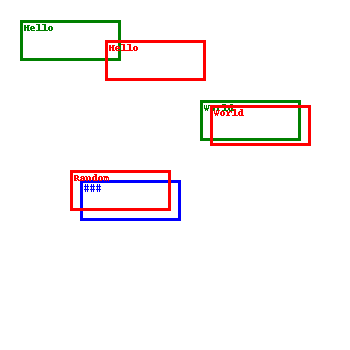

---Overall Metric---
Precision: 0.5, Recall: 0.5, HMean: 0.5

---Per Sample Metric---
---Matched---
MATCHED GT 1 and MATCHED PRED 1 IoU: 0.65

---Ignored---
IGNORED GT 2 and IGNORED PRED 2 IoU: 0.51

---Unmatched---
UNMATCHED GT 0 and UNMATCHED PRED 0 IoU: 0.04



In [6]:
eval_config = {
    "IOU_CONSTRAINT": 0.5,
    "AREA_PRECISION_CONSTRAINT": 0.5,
    "WORD_SPOTTING": True,
}

gtPointsList = [
    [20, 20, 120, 60, "Hello"],
    [200, 100, 300, 140, "World"],
    [80, 180, 180, 220, "###"],
]
detPointsList = [
    [105, 40, 205, 80, "Hello"],
    [210, 105, 310, 145, "World"],
    [70, 170, 170, 210, "Random"],
]

img_id = "img_1"
gt_dict = {img_id: gtPointsList}
det_dict = {img_id: detPointsList}

demo_img = draw_img(gtPointsList, detPointsList, 350)
demo_img.show()
resDict = evaluation(gt_dict, det_dict, eval_config)
precision, recall, hmean = (
    resDict["method"]["precision"],
    resDict["method"]["recall"],
    resDict["method"]["hmean"],
)

print("---Overall Metric---")
print(
    f"Precision: {round(precision, 2)}, Recall: {round(recall, 2)}, HMean:"
    f" {round(hmean, 2)}\n"
)

matched_str, ignore_str, unmatched_str = format_dict(resDict, img_id)

print("---Per Sample Metric---")

if matched_str != "":
    print("---Matched---")
    print(matched_str)

if ignore_str != "":
    print("---Ignored---")
    print(ignore_str)

if unmatched_str != "":
    print("---Unmatched---")
    print(unmatched_str)

### Example 2

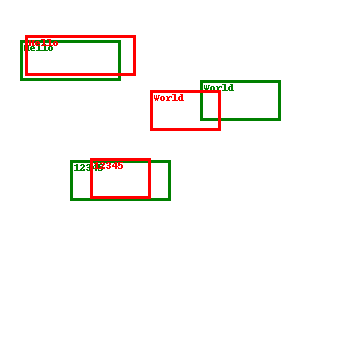

---Overall Metric---
Precision: 0.67, Recall: 0.67, HMean: 0.67

---Per Sample Metric---
---Matched---
MATCHED GT 0 and MATCHED PRED 0 IoU: 0.66
MATCHED GT 2 and MATCHED PRED 2 IoU: 0.55

---Unmatched---
UNMATCHED GT 1 and UNMATCHED PRED 1 IoU: 0.11



In [7]:
eval_config = {
    "IOU_CONSTRAINT": 0.5,
    "AREA_PRECISION_CONSTRAINT": 0.5,
    "WORD_SPOTTING": True,
}

gtPointsList = [
    [20, 40, 120, 80, "Hello"],
    [200, 80, 280, 120, "World"],
    [70, 160, 170, 200, "12345"],
]
detPointsList = [
    [25, 35, 135, 75, "Hello"],
    [150, 90, 220, 130, "World"],
    [90, 158, 150, 198, "12345"],
]

img_id = "img_2"
gt_dict = {img_id: gtPointsList}
det_dict = {img_id: detPointsList}

demo_img = draw_img(gtPointsList, detPointsList, 350)
demo_img.show()
resDict = evaluation(gt_dict, det_dict, eval_config)
precision, recall, hmean = (
    resDict["method"]["precision"],
    resDict["method"]["recall"],
    resDict["method"]["hmean"],
)

print("---Overall Metric---")
print(
    f"Precision: {round(precision, 2)}, Recall: {round(recall, 2)}, HMean:"
    f" {round(hmean, 2)}\n"
)

matched_str, ignore_str, unmatched_str = format_dict(resDict, img_id)

print("---Per Sample Metric---")

if matched_str != "":
    print("---Matched---")
    print(matched_str)

if ignore_str != "":
    print("---Ignored---")
    print(ignore_str)

if unmatched_str != "":
    print("---Unmatched---")
    print(unmatched_str)

### Example 3

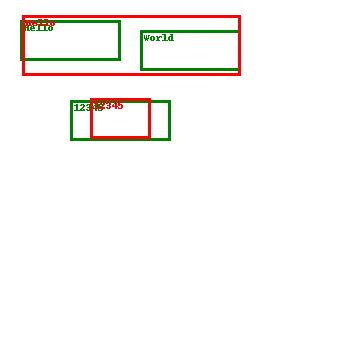

---Overall Metric---
Precision: 0.5, Recall: 0.33, HMean: 0.4

---Per Sample Metric---
---Matched---
MATCHED GT 2 and MATCHED PRED 1 IoU: 0.55

---Unmatched---
UNMATCHED GT 0 and UNMATCHED PRED 0 IoU: 0.3
UNMATCHED GT 1 and UNMATCHED PRED 0 IoU: 0.31



In [8]:
eval_config = {
    "IOU_CONSTRAINT": 0.5,
    "AREA_PRECISION_CONSTRAINT": 0.5,
    "WORD_SPOTTING": True,
}

gtPointsList = [
    [20, 20, 120, 60, "Hello"],
    [140, 30, 240, 70, "World"],
    [70, 100, 170, 140, "12345"],
]
detPointsList = [[22, 15, 240, 75, "Hello"], [90, 98, 150, 138, "12345"]]

img_id = "img_3"
gt_dict = {img_id: gtPointsList}
det_dict = {img_id: detPointsList}

demo_img = draw_img(gtPointsList, detPointsList, 350)
demo_img.show()
resDict = evaluation(gt_dict, det_dict, eval_config)
precision, recall, hmean = (
    resDict["method"]["precision"],
    resDict["method"]["recall"],
    resDict["method"]["hmean"],
)

print("---Overall Metric---")
print(
    f"Precision: {round(precision, 2)}, Recall: {round(recall, 2)}, HMean:"
    f" {round(hmean, 2)}\n"
)

matched_str, ignore_str, unmatched_str = format_dict(resDict, img_id)

print("---Per Sample Metric---")

if matched_str != "":
    print("---Matched---")
    print(matched_str)

if ignore_str != "":
    print("---Ignored---")
    print(ignore_str)

if unmatched_str != "":
    print("---Unmatched---")
    print(unmatched_str)

### Example 4

In [9]:
eval_config = {
    "IOU_CONSTRAINT": 0.5,
    "AREA_PRECISION_CONSTRAINT": 0.5,
    "WORD_SPOTTING": True,
}

gt_dict = {
    "img_1": [
        [20, 20, 120, 60, "Hello"],
        [200, 100, 300, 140, "World"],
        [80, 180, 180, 220, "###"],
    ],
    "img_2": [
        [20, 40, 120, 80, "Hello"],
        [200, 80, 280, 120, "World"],
        [70, 160, 170, 200, "12345"],
    ],
    "img_3": [
        [20, 20, 120, 60, "Hello"],
        [140, 30, 240, 70, "World"],
        [70, 100, 170, 140, "12345"],
    ],
}
det_dict = {
    "img_1": [
        [105, 40, 205, 80, "Hello"],
        [210, 105, 310, 145, "World"],
        [70, 170, 170, 210, "###"],
    ],
    "img_2": [
        [25, 35, 135, 75, "Hello"],
        [150, 90, 220, 130, "World"],
        [90, 158, 150, 198, "12345"],
    ],
    "img_3": [[22, 15, 240, 75, "Hello"], [90, 98, 150, 138, "World"]],
}

resDict = evaluation(gt_dict, det_dict, eval_config)
precision, recall, hmean = (
    resDict["method"]["precision"],
    resDict["method"]["recall"],
    resDict["method"]["hmean"],
)

print("---Overall Metric---")
print(
    f"Precision: {round(precision, 2)}, Recall: {round(recall, 2)}, HMean:"
    f" {round(hmean, 2)}\n"
)

for img_id in gt_dict.keys():
    matched_str, ignore_str, unmatched_str = format_dict(resDict, img_id)

    precision, recall, hmean = (
        resDict["per_sample"][img_id]["precision"],
        resDict["per_sample"][img_id]["recall"],
        resDict["per_sample"][img_id]["hmean"],
    )

    print(f"---Per Sample Metric of {img_id}---")
    print(
        f"Precision: {round(precision, 2)}, Recall: {round(recall, 2)}, HMean:"
        f" {round(hmean, 2)}\n"
    )

    if matched_str != "":
        print("---Matched---")
        print(matched_str)

    if ignore_str != "":
        print("---Ignored---")
        print(ignore_str)

    if unmatched_str != "":
        print("---Unmatched---")
        print(unmatched_str)

---Overall Metric---
Precision: 0.43, Recall: 0.38, HMean: 0.4

---Per Sample Metric of img_1---
Precision: 0.5, Recall: 0.5, HMean: 0.5

---Matched---
MATCHED GT 1 and MATCHED PRED 1 IoU: 0.65

---Ignored---
IGNORED GT 2 and IGNORED PRED 2 IoU: 0.51

---Unmatched---
UNMATCHED GT 0 and UNMATCHED PRED 0 IoU: 0.04

---Per Sample Metric of img_2---
Precision: 0.67, Recall: 0.67, HMean: 0.67

---Matched---
MATCHED GT 0 and MATCHED PRED 0 IoU: 0.66
MATCHED GT 2 and MATCHED PRED 2 IoU: 0.55

---Unmatched---
UNMATCHED GT 1 and UNMATCHED PRED 1 IoU: 0.11

---Per Sample Metric of img_3---
Precision: 0.0, Recall: 0.0, HMean: 0

---Unmatched---
UNMATCHED GT 0 and UNMATCHED PRED 0 IoU: 0.3
UNMATCHED GT 0 and UNMATCHED PRED 1 IoU: 0.0
UNMATCHED GT 1 and UNMATCHED PRED 0 IoU: 0.31
UNMATCHED GT 1 and UNMATCHED PRED 1 IoU: 0.0
UNMATCHED GT 2 and UNMATCHED PRED 0 IoU: 0.0
UNMATCHED GT 2 and UNMATCHED PRED 1 IoU: 0.55

